In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# Context

From previous feature analysis, we know that, from the `SimulationModelParameters` table, the variables

- *acure_carb_ff_ems*
- *acure_carb_bb_ems*
- *acure_carb_res_ems*
- *acure_anth_so2*

have not been nominaly changed. However, additional internal information tells us that, even though they do change in the map, the following variables have not really changed from simulation sample to simulation sample in that ensemble:

- *...ff_ems...*
- *..bb_ems...*
- *..res_ems...*

In [8]:
feature_filter = ['acure_anth_so2', 'ff_ems', 'bb_ems', 'res_ems']

# Filter relevant features

In [7]:
# get the data
parameters = c3.SimulationModelParameters.fetch().objs
parameters = parameters.toJson()
df = pd.DataFrame(parameters)
simulations = pd.DataFrame(df['id'])
X = df[df.columns[5:]]

In [11]:
filtered_feats = list(X.columns)

for feat in X.columns:
    for filt in feature_filter:
        if filt in feat:
            filtered_feats.remove(feat)
            
X = X[filtered_feats]

In [12]:
X

,acure_bl_nuc,acure_ait_width,acure_cloud_ph,acure_carb_ff_diam,acure_carb_bb_diam,acure_carb_res_diam,acure_prim_so4_diam,acure_sea_spray,acure_volc_so2,acure_bvoc_soa,...,acure_oxidants_o3,bparam,two_d_fsd_factor,c_r_correl,acure_autoconv_exp_lwp,acure_autoconv_exp_nd,dbsdtbs_turb_0,ai,m_ci,a_ent_1_rp
0,0.500000,0.650000,0.396000,0.500000,0.095238,0.146341,1.000000,0.500000,0.283146,0.466533,...,0.576175,0.500000,0.400000,0.900000,0.275862,0.605000,0.150000,0.514000,0.333333,0.460000
1,0.470000,0.500000,0.500000,0.470000,0.500000,0.500000,0.500000,0.530000,0.500000,0.500000,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
2,0.969888,0.083081,0.478474,0.477148,0.690581,0.255841,0.516864,0.989837,0.104736,0.763283,...,0.017104,0.927093,0.833905,0.610920,0.993935,0.755788,0.774187,0.960911,0.988952,0.508725
3,0.132847,0.445265,0.390414,0.080640,0.283143,0.377899,0.792391,0.607072,0.746781,0.009958,...,0.010731,0.950732,0.902536,0.780157,0.267910,0.018570,0.106893,0.218308,0.163327,0.936031
4,0.058261,0.630422,0.132292,0.091643,0.807161,0.750013,0.490741,0.545087,0.334763,0.361367,...,0.779013,0.129769,0.712185,0.552866,0.328090,0.651008,0.613814,0.101666,0.254514,0.089525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,0.591530,0.996801,0.170201,0.974433,0.640570,0.511640,0.119761,0.745082,0.701852,0.950993,...,0.836703,0.515917,0.891746,0.418227,0.732156,0.900471,0.035621,0.175431,0.482366,0.400788
217,0.774235,0.165151,0.881014,0.024792,0.736286,0.083007,0.807389,0.340840,0.046537,0.097677,...,0.787844,0.786932,0.231686,0.840574,0.349984,0.433408,0.930975,0.119901,0.777433,0.116056
218,0.227072,0.231834,0.185796,0.659394,0.615861,0.140808,0.243118,0.500152,0.683347,0.655217,...,0.709293,0.204519,0.096402,0.147632,0.313749,0.741739,0.144573,0.488763,0.245905,0.686731
219,0.047377,0.633909,0.721278,0.162007,0.785446,0.622816,0.827818,0.062070,0.744257,0.973379,...,0.214451,0.303059,0.898960,0.114170,0.725976,0.766313,0.259877,0.872825,0.966951,0.826032


#### Conclusion

We are then left with 33 features.

# Get datasets 

In [20]:
output_name = "mass_BC_acc"
timestamp = "2017-08-19T09:00:00.000"

metric_name = "Average_" + output_name + "_SimulationSample" 
metric_descr = "Calculates average of " + output_name + " for a given set of SimulationSample"
metric_expr = "avg(avg(normalized.data." + output_name + "))"
metric = c3.SimpleMetric(id = metric_name,
                                    name = metric_name,
                                    description = metric_descr,
                                    srcType = "SimulationSample",
                                    path = "output",  # the timeseries is in the output field of SimSam
                                    expression = metric_expr
                                  )
    
# define metric spec
spec = c3.EvalMetricsSpec(
                                    ids = simulations['id'],
                                    expressions = [metric_name],
                                    start = timestamp,
                                    end = timestamp,
                                    interval = "SECOND" 
                                )

# evaluate metric, cast it to pandas
evalMetricsResult = c3.SimulationSample.evalMetricsWithMetadata(
                                                                        spec=spec,
                                                                        overrideMetrics=[metric]
                                                                    )
y = c3.EvalMetricsResult.toPandas(result=evalMetricsResult)
    
    
    # split into train/test sets
datasets = train_test_split(X, y, test_size=0.1, random_state=42)
    
    # cast into c3 Datasets
X_train = c3.Dataset.fromPython(datasets[0])
X_test = c3.Dataset.fromPython(datasets[1])
y_train = c3.Dataset.fromPython(datasets[2])
y_test = c3.Dataset.fromPython(datasets[3])

# PCA and Gaussian Regression

We are going to use all 33 PCA components and an RBF kernel, for demonstration purposes.

### 1. Build pipeline

In [28]:
# first pipe is PCA
pca = c3.MLStep(
    name="PCA",
    pipe=c3.PrincipalComponentAnalysisPipe(
        technique=c3.PrincipalComponentAnalysisTechnique(
            nComponents=33
        )
    )
)


# second pipe is GP Regression
GPR_kernel = c3.SklearnGPRKernelRBF(lengthScale=1.0).build().kernel

gp_reg = c3.MLStep(
    name="GPR",
    pipe=c3.GaussianProcessRegressionPipe(
        technique=c3.GaussianProcessRegressionTechnique(
            randomState=42,
            kernel=GPR_kernel
        )
    )
)

# put pipes together in pipeline
pipeline = c3.MLSerialPipeline(
    steps=[
        pca,
        gp_reg
    ],
    scoringMetrics=c3.MLScoringMetric.toScoringMetricMap(scoringMetricList=[c3.MLRSquaredMetric()])
)

### 2. Train

In [29]:
trained_pipeline = pipeline.train(input=X_train, targetOutput=y_train)

### 3. Score

In [30]:
score = trained_pipeline.score(input=X_test, targetOutput=y_test)
score

c3.Mapp<string, double>({'MLRSquaredMetric': 0.7208148079948009})

### 4. Predict

In [31]:
y_test_preds = trained_pipeline.process(input=X_test)
y_test_preds = c3.Dataset.toPandas(dataset=y_test_preds)
y_test_preds

,0
0,1.573746e-10
1,1.567009e-10
2,5.511280e-11
3,3.041367e-10
4,1.447975e-10
5,1.501790e-10
6,1.241292e-10
7,1.136993e-10
8,2.103606e-10
9,4.898526e-11


In [35]:
y_test_df = c3.Dataset.toPandas(dataset=y_test)

In [38]:
x = list(range(23))

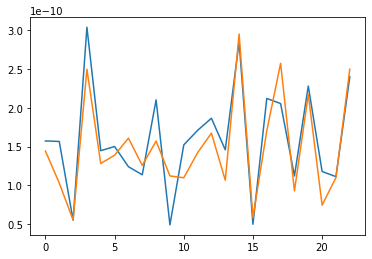

In [39]:
plt.figure()
plt.plot(x, y_test_preds)
plt.plot(x, y_test_df)